In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown https://drive.google.com/uc?id=1KR_7-SMuvH0rLmZawqoIZYm6V1mVjHrA 

Downloading...
From: https://drive.google.com/uc?id=1KR_7-SMuvH0rLmZawqoIZYm6V1mVjHrA
To: /content/data.zip
100% 1.14G/1.14G [00:06<00:00, 176MB/s]


In [ ]:
!unzip /content/drive/MyDrive/data.zip -d /content/drive/MyDrive/data

Archive:  /content/drive/MyDrive/data.zip
   creating: /content/drive/MyDrive/data/data/
  inflating: /content/drive/MyDrive/data/data/normal_2072.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2881.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2942.jpg  
  inflating: /content/drive/MyDrive/data/data/cataract_860.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_788.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2981.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2969.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_736.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2122.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_1134.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_868.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_930.jpg  
  inflating: /content/drive/MyDrive/data/data/normal_2023.jpg  
  inflating: /content/drive/MyDrive/data/data/cataract_363.jpg  
  inflating: /con

In [ ]:
import numpy as np
import pandas as pd
import tensorflow 
from tensorflow.keras.utils import  load_img 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size=32
filenames = os.listdir("/content/drive/MyDrive/data/data")
categories = []
num_samples=0
normal=0
cataract=0
for filename in filenames:
    num_samples=num_samples+1
    category = filename.split('_')[0]
    if category == 'normal':
        categories.append(0)
        normal=normal+1
    else:
        categories.append(1)
        cataract=cataract+1    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


df["category"] = df["category"].replace({0: 'normal', 1: 'cataract'}) 

train_df, validate_df = train_test_split(df, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train = train_df.shape[0]
validate = validate_df.shape[0]




print(num_samples , normal , cataract)

2922 2194 728


In [ ]:
train_df.count

<bound method DataFrame.count of               filename  category
0      normal_1779.jpg    normal
1      normal_2755.jpg    normal
2      normal_2055.jpg    normal
3     cataract_980.jpg  cataract
4       normal_666.jpg    normal
...                ...       ...
2624    normal_244.jpg    normal
2625   normal_2373.jpg    normal
2626   normal_1669.jpg    normal
2627  cataract_691.jpg  cataract
2628  cataract_576.jpg  cataract

[2629 rows x 2 columns]>

In [ ]:
validate_df.count

<bound method DataFrame.count of              filename  category
0     normal_2020.jpg    normal
1     normal_1341.jpg    normal
2    cataract_454.jpg  cataract
3    cataract_325.jpg  cataract
4    cataract_174.jpg  cataract
..                ...       ...
288  cataract_845.jpg  cataract
289  cataract_487.jpg  cataract
290  cataract_525.jpg  cataract
291    normal_458.jpg    normal
292   normal_1584.jpg    normal

[293 rows x 2 columns]>

In [ ]:
train_datagen = ImageDataGenerator(
    #rotation_range=15,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/data/data", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/data/data", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2629 validated image filenames belonging to 2 classes.
Found 293 validated image filenames belonging to 2 classes.


In [ ]:


print(validation_generator.class_indices)
print(validation_generator.n)
print(len(validation_generator))


{'cataract': 0, 'normal': 1}
293
10


In [ ]:
X_list = []
y_list = []
for i in range(validation_generator.__len__()):
    X, y = validation_generator.__getitem__(i)
    X_list.append(X)
    y_list.append(y)

X_val = np.concatenate(X_list, axis=0)
y_val1 = np.concatenate(y_list, axis=0)
y_val_argmax = np.argmax(y_val1, axis=1).astype('uint8')


X_val.shape, y_val1.shape, y_val_argmax.shape



((293, 128, 128, 3), (293, 2), (293,))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Activation , BatchNormalization , MaxPooling2D , Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

#earlystop = EarlyStopping(patience=10)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            #patience=2, 
                                            #verbose=1, 
                                            #factor=0.5, 
                                            #min_lr=0.00001)
#callbacks = [earlystop, learning_rate_reduction]


batch_size=32
epochs=10



stop = EarlyStopping(
    monitor = 'val_accuracy',
    mode='max',
    patience= 8,
    verbose = 2,
    restore_best_weights = True
)
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate//batch_size,
    steps_per_epoch=train//batch_size,
    callbacks=stop
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

<ipython-input-13-f7f7839c5524>:65: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
82/82 [==============================] - 113s 1s/step - loss: 0.4679 - accuracy: 0.7671 - val_loss: 0.3485 - val_accuracy: 0.8576
Epoch 2/10
82/82 [==============================] - 107s 1s/step - loss: 0.3061 - accuracy: 0.8698 - val_loss: 0.2241 - val_accuracy: 0.9132
Epoch 3/10
82/82 [==============================] - 111s 1s/step - loss: 0.2346 - accuracy: 0.9068 - val_loss: 0.2831 - val_accuracy: 0.8542
Epoch 4/10
82/82 [==============================] - 106s 1s/step - loss: 0.2092 - accuracy: 0.9118 - val_loss: 0.2942 - val_accuracy: 0.8160
Epoch 5/10
82/82 [==============================] - 104s 1s/step - loss: 0.2191 - accuracy: 0.9134 - val_loss: 0.1978 - val_accuracy: 0.9132
Epoch 6/10
82/82 [==============================] - 99s 1s/step - loss: 0.1843 - accuracy: 0.9226 - val_loss: 0.1873 - val_accuracy: 0.9201
Epoch 7/10
82/82 [==============================] - 99s 1s/step - loss: 0.1776 - accuracy: 0.9265 - val_loss: 0.1550 - val_accuracy: 0.9514
Epoch 8/10
82/8

In [ ]:
#model.save_weights("model.h5")
model.save('/content/drive/MyDrive/my_model')


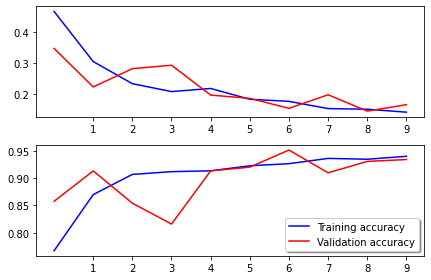

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
#ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

normal_1858.jpg 0 (2584, 2000)


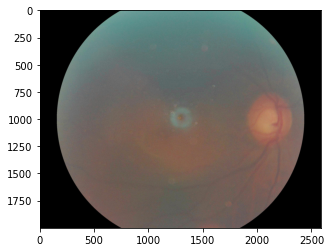

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/data/data/"+sample)
print( sample , image.category, image.size)
plt.imshow(image  )

In [ ]:
#model = load("model.h5")
new_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/my_model')

# Check its architecture
new_model.summary()


Downloading...
From: https://colab.research.google.com/drive/1pLp4bQgLxcEQVFdqL6ZZLGK-2oiAIWba?usp=sharing
To: /content/1pLp4bQgLxcEQVFdqL6ZZLGK-2oiAIWba?usp=sharing
71.6kB [00:00, 2.63MB/s]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                               

In [ ]:
def predict_images(dir, res_file):
  test_filenames = os.listdir(dir)
  test_df = pd.DataFrame({
    'filename': test_filenames
   })
  nb_samples = test_df.shape[0]

  test_gen = ImageDataGenerator(rescale=1./255)
  test_generator = test_gen.flow_from_dataframe( 
      test_df , 
      dir, 
      x_col='filename',
#      y_col=None,
      class_mode=None,
      target_size=IMAGE_SIZE,
      batch_size=batch_size,
      shuffle=False
  )
  #preds = model.predict_generator(validation_generator, 
  #                               steps=total_validate//batch_size + 1,
  #                               verbose=1)
  predict = new_model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size),
                                 verbose=1)

  test_df['category'] = np.argmax(predict, axis=-1)
  label_map = dict((v,k) for k,v in train_generator.class_indices.items())
  test_df['category'] = test_df['category'].replace(label_map)


  submission_df = test_df.copy()
  submission_df['id'] = submission_df['filename'].str.split('.').str[0]
  submission_df['label'] = submission_df['category']
  submission_df.drop(['filename', 'category'], axis=1, inplace=True)
  submission_df.to_csv(f'%s' %res_file, index=False)



In [ ]:
import numpy as np
trainableParams = np.sum([np.prod(v.get_shape()) for v in new_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in new_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print(trainableParams)
print(nonTrainableParams)
print(totalParams)

3304898
0.0
3304898.0


In [ ]:
# download test_images.zip
!gdown 16epIFeSWcYfcCyFCD6s2ZJrVQC4mKMlx
!unzip test_images.zip -d /content/drive/MyDrive

Downloading...
From: https://drive.google.com/uc?id=16epIFeSWcYfcCyFCD6s2ZJrVQC4mKMlx
To: /content/test_images.zip
100% 225k/225k [00:00<00:00, 131MB/s]
Archive:  test_images.zip
   creating: /content/drive/MyDrive/test_images/
  inflating: /content/drive/MyDrive/test_images/2.jpg  
  inflating: /content/drive/MyDrive/test_images/4.jpg  
  inflating: /content/drive/MyDrive/test_images/1.jpg  
  inflating: /content/drive/MyDrive/test_images/3.jpg  


In [ ]:
predict_images(dir='/content/test_images', res_file='result.csv')
# 'name' 'label': ['normal', 'cataract']

Found 4 validated image filenames.
1/1 [==============================] - 0s 41ms/step


<ipython-input-42-4803dab43f40>:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size),


In [ ]:
import pandas as pd
# result = pd.read_csv('/content/result.csv')
result = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'label': ['normal', 'cataract', 'normal', 'cataract']})
# ref = pd.read_csv('/content/ref.csv')
ref = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'true_label': ['cataract', 'normal', 'normal', 'cataract']})
merg = pd.merge(ref, result, on='name', how='left')

from sklearn.metrics import classification_report
print(classification_report(y_true=merg.true_label, y_pred=merg.label))

              precision    recall  f1-score   support

    cataract       0.50      0.50      0.50         2
      normal       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

